In [1]:
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import preprocessing

In [4]:
# This notebook will set up the data we need to run our linear regressions.

# First, load the datasets we will need.
pop = pd.read_csv("../data/CA_pop.csv")
crime = pd.read_csv("../data/clean_data.csv", low_memory=False)
lstops = pd.read_csv("../data/lstops_localized.csv")
parks = pd.read_csv("../data/parks_localized.csv")
commareas = pd.read_csv("../data/CommAreas.csv")

In [5]:
commareas

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,0,0,0,0,35,DOUGLAS,35,4.600462e+07,31027.054510
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,36,OAKLAND,36,1.691396e+07,19565.506153
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,0,0,0,0,37,FULLER PARK,37,1.991670e+07,25339.089750
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,0,0,0,0,38,GRAND BOULEVARD,38,4.849250e+07,28196.837157
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,39,KENWOOD,39,2.907174e+07,23325.167906
...,...,...,...,...,...,...,...,...,...,...
72,MULTIPOLYGON (((-87.69645961375822 41.70714491...,0,0,0,0,74,MOUNT GREENWOOD,74,7.558429e+07,48665.130539
73,MULTIPOLYGON (((-87.64215204651398 41.68508211...,0,0,0,0,75,MORGAN PARK,75,9.187734e+07,46396.419362
74,MULTIPOLYGON (((-87.83658087874365 41.98639611...,0,0,0,0,76,OHARE,76,3.718356e+08,173625.984660
75,MULTIPOLYGON (((-87.65455590025104 41.99816614...,0,0,0,0,77,EDGEWATER,77,4.844999e+07,31004.830946


In [3]:
# Now we need to get the columns that we need and build our data frames
# We will make two data frames: crime_time and conditions
# crime_time: Crime rates by Community 
# conditions: Acerage of parks and number of L train stops by Community

# First, we'll make conditions

parks1 = parks.filter(['ACRES','Community Area','Pop2010'], axis=1)
parks1 = parks1.groupby('Community Area')[['ACRES']].agg('sum')
parks1 = parks1.reset_index()
parks1.columns = ['Community Area','Acres']
pd.DataFrame.head(parks1)

,Community Area,Acres
0,1,284.460000
1,2,390.560000
2,3,30.740000
3,4,389.422277
4,5,1395.020000


In [65]:
lstops1 = lstops['Community Area'].value_counts()
lstops1 = lstops1.reset_index()
lstops1.columns = ['Community Area','Num L Stops']
lstops1['Num L Stops'] = lstops1['Num L Stops'].fillna(0)
pd.DataFrame.head(lstops1)

,Community Area,Num L Stops
0,32,50
1,28,48
2,24,38
3,29,36
4,7,36


In [66]:
pop.columns = ['Community Area', 'Pop2010','weights','total']
pd.DataFrame.head(pop)


# Do the same sort of grouping for any other datasets we want to consider

,Community Area,Pop2010,weights,total
0,1,63484,0.021921,2896016.0
1,2,73199,0.025276,NaN
2,3,63551,0.021944,NaN
3,4,44574,0.015391,NaN
4,5,31895,0.011013,NaN


In [68]:
# merge the datasets now to get all of the attributes of each community
# in one place.
# For now, we are only looking at two attributes, so we do a single merge
conditions = pd.merge(pop, parks1, left_on=['Community Area'], right_on=['Community Area'], how = 'left')
conditions = pd.merge(conditions, lstops1, left_on=['Community Area'], right_on=['Community Area'], how = 'left')

pd.DataFrame.head(conditions)
# Now conditions dataframe is ready and has all the information we need
# (until we examine more factors beyond Acres of park-space and number of L stops).

,Community Area,Pop2010,weights,total,Acres,Num L Stops
0,1,63484,0.021921,2896016.0,284.460000,16.0
1,2,73199,0.025276,NaN,390.560000,16.0
2,3,63551,0.021944,NaN,30.740000,22.0
3,4,44574,0.015391,NaN,389.422277,32.0
4,5,31895,0.011013,NaN,1395.020000,34.0


In [73]:
'''
Now we will make the crime_time dataframe.
We will calculate the crime rate for each Community for every month in the past
five years.

First, filter out the data before 2015
Second, calculate crime rate
  rate := total crime in that community / total crime that month
Third, build the crime_time dataset
'''
crime1 = crime.filter(['Month','Year','Community Area'])

#print(crime1.head())

after_2015 = crime1['Year'] >= 2010
crime1 = crime1[after_2015]
crime_CA = crime1.copy()
# print(crime1.head())

crime1.set_index('Year')
# print("The following dataframe has the number of crimes in each community for each month since Jan 2015:")


crime2 = crime1.groupby(['Year','Month','Community Area']).agg(count = ('Community Area','count'))
#print(crime2)

crime3 = crime2.reset_index()
# print(crime3)

# Get the total crimes reported per month
totals = crime2.groupby(['Year','Month']).agg('sum')
#print(totals)
tot = totals.reset_index()
# print(tot)

wow_crimes = pd.merge(crime3, tot, left_on=['Year','Month'], right_on=['Year', 'Month'], how = 'left')

In [128]:
'''
Calculate crime rate to be number of crimes, per neighborhood each month of each year, per 1,000 people.

Encode month, year, and whether the crime rate is in a month of lockdown, as some other factors to include.

Normalize acres and population density to be 0 <= x <= 78.17 since their units are different from crime rate -
we normalize to the minimum and the maximum of the crime rates.
'''

# Calculate the percent of total crime in the
wow_crimes['percent'] = wow_crimes['count_x']/wow_crimes['count_y']

#Calculate crime rate as crime per 1.000 people (Number of Crime per 1000 people)
wow_crimes = pd.merge(wow_crimes,conditions[['Community Area','Pop2010', 'Acres']],on=['Community Area'], how = 'left')
wow_crimes['rate'] = 1000 * wow_crimes['count_x'] / wow_crimes['Pop2010']

#Pop Density (Number of People Per Acre of Land)
wow_crimes['Pop Density'] = wow_crimes['Pop2010'] / wow_crimes['Acres']
print("\nCompleted crime_time dataset:\n")

# create indicator for seasonality, each month of crime rate
month_encode = pd.get_dummies(wow_crimes.Month, prefix='Month')

new_crime = pd.concat([wow_crimes, month_encode], axis=1)
# lockdown was march-may 2020

def is_lockdown(row):
    if 3 <= row["Month"] <= 5 and row["Year"] == 2020: 
        return 1
    return 0

# TO DO: scale population density and acres 
# wow_crimes['Pop Density'] = min_max_scaler.fit_transform(wow_crimes['Pop Density'])
# wow_crimes['Acres'] = min_max_scaler.fit_transform(wow_crimes['Acres'])


new_crime = new_crime.assign(lockdown = new_crime.apply(is_lockdown, axis = 1))
# we will only be using data from 2015 onwards, to ignore the overal historical effect!
new_crime = new_crime[new_crime['Year'] >= 2015]

pd.DataFrame.head(new_crime)



Completed crime_time dataset:



,Year,Month,Community Area,count_x,count_y,percent,Pop2010_x,Acres_x,rate,Pop Density,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lockdown
4629,2015,1,1.0,295,20918,0.014103,63484.0,284.460000,4.646840,223.173733,...,0,0,0,0,0,0,0,0,0,0
4630,2015,1,2.0,251,20918,0.011999,73199.0,390.560000,3.429009,187.420627,...,0,0,0,0,0,0,0,0,0,0
4631,2015,1,3.0,245,20918,0.011712,63551.0,30.740000,3.855171,2067.371503,...,0,0,0,0,0,0,0,0,0,0
4632,2015,1,4.0,156,20918,0.007458,44574.0,389.422277,3.499798,114.461865,...,0,0,0,0,0,0,0,0,0,0
4633,2015,1,5.0,112,20918,0.005354,31895.0,1395.020000,3.511522,22.863471,...,0,0,0,0,0,0,0,0,0,0


In [129]:
# In order to classify logistic regression rate as 
# We look at overall statistics and trend of rate 
pd.DataFrame.describe(new_crime['rate'])

count    5467.000000
mean        8.077782
std         6.570124
min         0.929146
25%         3.996975
50%         5.931667
75%        10.440825
max        78.166951
Name: rate, dtype: float64

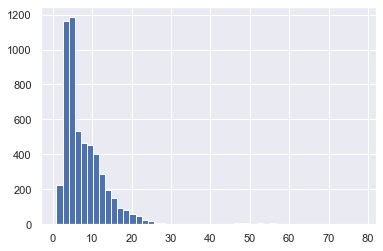

In [130]:
plt.hist(new_crime['rate'], bins=50)
plt.show()

In [131]:
# separate the dataset into two models for comparison pre-COVID and post_COVID
post_covid = new_crime[(new_crime['Year'] == 2020) & (new_crime['Month'] >= 2)]
# include years 2015-2019 and the January before COVID cases started appearing
pre_covid = new_crime[(new_crime['Year'] >= 2015) & (new_crime['Year'] < 2020)].append(new_crime[(new_crime['Year'] == 2020) & (new_crime['Month'] == 1)])

In [108]:
# let's inspect the distributions of the crime rates pre- and post-covid
print("Crime rate statistics, separated by community area and by month, January 2015 - January 2020")
print(pd.DataFrame.describe(pre_covid['rate']))
print("Crime rate statistics, separated by community area and by month, February 2020 - November 2020")
print(pd.DataFrame.describe(post_covid['rate']))

Crime rate statistics, separated by community area and by month, January 2015 - January 2020
count    4697.000000
mean        8.366454
std         6.815969
min         1.154632
25%         4.191049
50%         6.117047
75%        10.738806
max        78.166951
Name: rate, dtype: float64
Crime rate statistics, separated by community area and by month, February 2020 - November 2020
count    770.000000
mean       6.316887
std        4.417300
min        0.929146
25%        3.242132
50%        4.520394
75%        8.633913
max       39.358067
Name: rate, dtype: float64


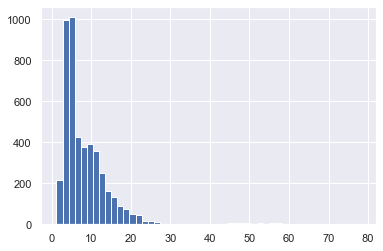

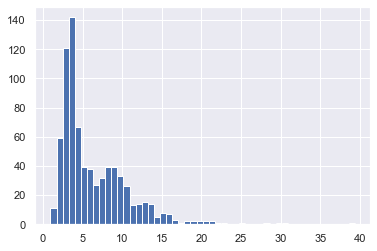

In [109]:
plt.hist(pre_covid['rate'], bins=50)
plt.show()
plt.hist(post_covid['rate'], bins=50)
plt.show()

In [146]:
# It seems that the distribution has shifted greatly to the left (which is what
# we expected from our initial data exploration. 

# We choose to use the median over all the data we are using, 
# 5.93 as the classfier between low/high crime rates. 

# First model - pre-COVID.
import statsmodels.api as sm 

'''
TO DO: Add L-stops as a predictor in the dataset new_crime - missing for some reason
'''

# identify the labels of predictors we are using
# predictors = ['Pop Density', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 
#               'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
#               'Month_10', 'Month_11', 'Month_12', 'Acres', 'lockdown', 'intercept']
predictors = ['Pop Density', 'Month', 'Acres', 'intercept']

# add classification for whether
pre_covid['classification'] = pre_covid['rate'] > 5.93
# add intercept term to model (required)
pre_covid['intercept'] = 1.0
logit = sm.Logit(pre_covid['classification'], pre_covid[predictors])

# remove low variance 
result = logit.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.681732
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         classification   No. Observations:                 4697
Model:                          Logit   Df Residuals:                     4693
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                 0.01586
Time:                        23:13:05   Log-Likelihood:                -3202.1
converged:                       True   LL-Null:                       -3253.7
Covariance Type:            nonrobust   LLR p-value:                 3.131e-22
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Pop Density    -0.0009      0.000     -7.504      0.000      -0.001      -0.001
Month           0.0142    

In [118]:
pre_covid['classification'] = pre_covid['rate'] > 5.93
print(pre_covid['classification'])

4629    False
4630    False
4631    False
4632    False
4633    False
        ...  
9321     True
9322    False
9323     True
9324     True
9325    False
Name: classification, Length: 4697, dtype: bool


In [100]:
print(new_crime.columns)

Index(['Year', 'Month', 'Community Area', 'count_x', 'count_y', 'percent',
       'Pop2010', 'Acres', 'rate', 'Pop Density', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'lockdown'],
      dtype='object')


In [ ]:
# Below are experimentation with previous linear models 

In [6]:
# We then isolate the rates according to each Community Area to find
#dict to store average crime rates
ca_average = {} 

#dict to store df for each community
ca_rates = {}

for i in range(1,78):
    area_rate = wow_crimes[wow_crimes['Community Area'] == i]
    ca_rates[i] = area_rate
    average = area_rate['rate'].mean()
    d=ca_average[i] = average

print(ca_rates)

{1:        Year  Month  Community Area  count_x  count_y      rate
0      2010      1             1.0      434    29222  0.014852
77     2010      2             1.0      359    24938  0.014396
155    2010      3             1.0      492    32320  0.015223
232    2010      4             1.0      525    31659  0.016583
310    2010      5             1.0      533    33393  0.015961
...     ...    ...             ...      ...      ...       ...
9711   2020      7             1.0      290    19349  0.014988
9788   2020      8             1.0      315    19610  0.016063
9865   2020      9             1.0      279    17604  0.015849
9942   2020     10             1.0      294    17915  0.016411
10019  2020     11             1.0      156    11218  0.013906

[131 rows x 6 columns], 2:        Year  Month  Community Area  count_x  count_y      rate
1      2010      1             2.0      388    29222  0.013278
78     2010      2             2.0      337    24938  0.013514
156    2010      3     

In [7]:
#segment into 2015-2019 and 2020 for each community area
d_rate = {}
for i in range(1,78):
    dd = {}
    ca_data = ca_rates[i]
    old_data = ca_data[ca_data['Year'] != 2020]
    new_data = ca_data[ca_data['Year'] == 2020]
    dd['old'] = old_data
    dd['new'] = new_data
    d_rate[i] = dd
print(d_rate)

    

{1: {'old':       Year  Month  Community Area  count_x  count_y      rate
0     2010      1             1.0      434    29222  0.014852
77    2010      2             1.0      359    24938  0.014396
155   2010      3             1.0      492    32320  0.015223
232   2010      4             1.0      525    31659  0.016583
310   2010      5             1.0      533    33393  0.015961
...    ...    ...             ...      ...      ...       ...
8864  2019      8             1.0      401    24354  0.016465
8941  2019      9             1.0      378    22393  0.016880
9018  2019     10             1.0      347    21637  0.016037
9095  2019     11             1.0      298    19886  0.014985
9172  2019     12             1.0      356    20736  0.017168

[120 rows x 6 columns], 'new':        Year  Month  Community Area  count_x  count_y      rate
9249   2020      1             1.0      318    19704  0.016139
9326   2020      2             1.0      290    18064  0.016054
9403   2020      3     

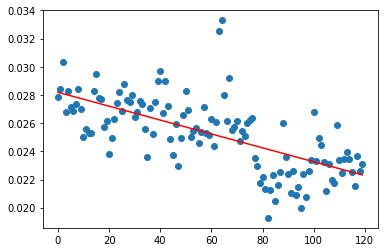

In [8]:
from sklearn.linear_model import LinearRegression as lr
import matplotlib.pyplot as plt
import datetime
import numpy as np

#test plot of rate over five years for CA 68
Y1 = d_rate[68]['old']['rate']
X1 = range(len(Y1))

X1 = np.array(X1)
Y1 = Y1.to_numpy()
Y = Y1.reshape(-1,1)
X = X1.reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

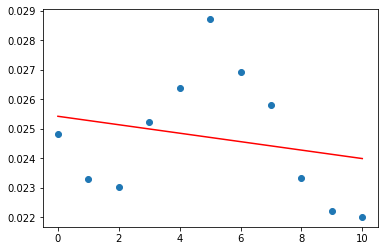

In [9]:
#test plot of rate over five years
Y1 = d_rate[68]['new']['rate']
X1 = range(len(Y1))

X1 = np.array(X1)
Y1 = Y1.to_numpy()
Y = Y1.reshape(-1,1)
X = X1.reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

In [10]:
#given seasonality of data, it makes more sense to compare month to month by year instead of yearly data 
# so we resegment by month for each community area
#SKIP FOR NOW

In [11]:
#figure out old_rate vs new_rate for each CA (averaging over all years past to average of this year to account for seasonal data)
#note here: does not account for slope over time as all data points over last 15 years treated equally

seq = range(1,78)
list_old = []
list_new = []
#create average over past before 2020
for i in range(1,78):
    list_old.append(d_rate[i]['old']['rate'].mean())
    list_new.append(d_rate[i]['new']['rate'].mean())
    
df = pd.DataFrame(seq, columns = ['Community Area'])
df['old_rate'] = list_old
df['new_rate'] = list_new
df['percent_change'] = ((df['new_rate'] - df['old_rate']) / df['old_rate'])*100
df


,Community Area,old_rate,new_rate,percent_change
0,1,0.014497,0.015460,6.642835
1,2,0.012658,0.014529,14.781381
2,3,0.013660,0.013953,2.150513
3,4,0.007037,0.008800,25.060247
4,5,0.005383,0.005360,-0.421610
...,...,...,...,...
72,73,0.012008,0.012501,4.103923
73,74,0.002186,0.002263,3.543674
74,75,0.007931,0.008134,2.559431
75,76,0.006283,0.005221,-16.900475


In [12]:
#merge with conditions
df_final = pd.merge(df, conditions, left_on=['Community Area'], right_on=['Community Area'], how = 'left')
df_final['Num L Stops'] = df_final['Num L Stops'].fillna(0)
df_final['Acres'] = df_final['Acres'].fillna(0)
df_final

,Community Area,old_rate,new_rate,percent_change,Pop2010,weights,total,Acres,Num L Stops
0,1,0.014497,0.015460,6.642835,63484,0.021921,2896016.0,284.460000,16.0
1,2,0.012658,0.014529,14.781381,73199,0.025276,NaN,390.560000,16.0
2,3,0.013660,0.013953,2.150513,63551,0.021944,NaN,30.740000,22.0
3,4,0.007037,0.008800,25.060247,44574,0.015391,NaN,389.422277,32.0
4,5,0.005383,0.005360,-0.421610,31895,0.011013,NaN,1395.020000,34.0
...,...,...,...,...,...,...,...,...,...
72,73,0.012008,0.012501,4.103923,29843,0.010305,NaN,527.615113,6.0
73,74,0.002186,0.002263,3.543674,18820,0.006499,NaN,92.960000,0.0
74,75,0.007931,0.008134,2.559431,25226,0.008711,NaN,504.995113,2.0
75,76,0.006283,0.005221,-16.900475,11956,0.004128,NaN,120.980000,6.0


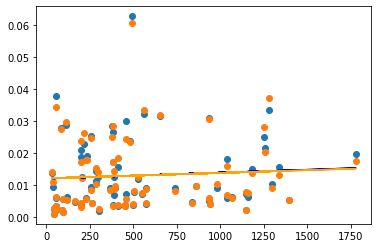

In [13]:
#greenspace vs. crime rate for each community area

#mapping greenspace by old_rate in crime 

X = df_final['Acres'].to_numpy().reshape(-1,1)
Y = df_final['old_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'blue')

#mapping greenspace by new_rate in crime 
X = df_final['Acres'].to_numpy().reshape(-1,1)
Y = df_final['new_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'orange')

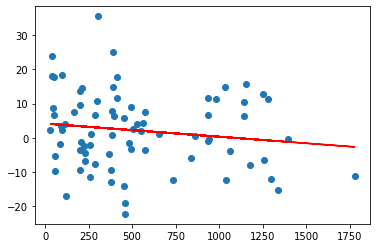

In [14]:

#mapping greenspace by percent change in crime 
X = df_final['Acres'].to_numpy().reshape(-1,1)
Y = df_final['percent_change'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

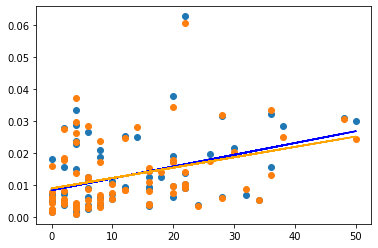

In [15]:
#mapping lstops by old_rate in crime 
X = df_final['Num L Stops'].to_numpy().reshape(-1,1)
Y = df_final['old_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'blue')

#mapping lstops by new_rate in crime 
X = df_final['Num L Stops'].to_numpy().reshape(-1,1)
Y = df_final['new_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'orange')

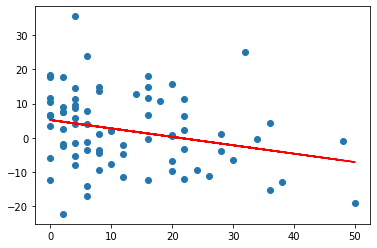

In [16]:
#mapping lstops by percent change in crime 
X = df_final['Num L Stops'].to_numpy().reshape(-1,1)
Y = df_final['percent_change'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

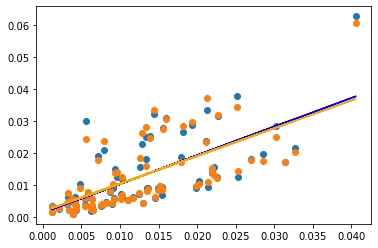

In [17]:
#mapping pop density with old_rate in crime 

X = df_final['weights'].to_numpy().reshape(-1,1)
Y = df_final['old_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'blue')

#mapping pop density with new_rate in crime 

X = df_final['weights'].to_numpy().reshape(-1,1)
Y = df_final['new_rate'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'orange')

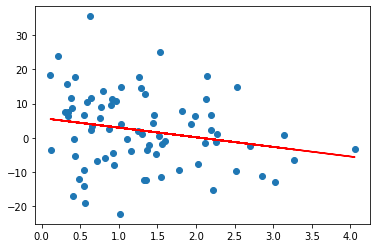

In [18]:
#mapping pop density by percent change in crime 

X = (df_final['weights']*100).to_numpy().reshape(-1,1)
Y = df_final['percent_change'].to_numpy().reshape(-1,1)

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X,Y)
plt.plot(X,Y_pred, color = 'red')

In [29]:
#multiple linear regression attempt at old_rate
import statsmodels.api as sm

X = df_final[['weights','Acres','Num L Stops']]
Y = df_final['old_rate']

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

print('Intercept: \n', linear_regressor.intercept_)
print('Coefficients: \n', linear_regressor.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

#thanku to https://datatofish.com/multiple-linear-regression-python/

Intercept: 
 0.0006877756190653561
Coefficients: 
 [ 8.13734381e-01 -4.77720711e-07  1.59109428e-04]
                            OLS Regression Results                            
Dep. Variable:               old_rate   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     23.49
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           9.52e-11
Time:                        01:03:36   Log-Likelihood:                 264.08
No. Observations:                  77   AIC:                            -520.2
Df Residuals:                      73   BIC:                            -510.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [31]:
#multiple linear regression attempt at new_rate

X = df_final[['weights','Acres','Num L Stops']]
Y = df_final['new_rate']

linear_regressor = lr()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)

print('Intercept: \n', linear_regressor.intercept_)
print('Coefficients: \n', linear_regressor.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 0.001223626326683212
Coefficients: 
 [ 8.06667799e-01 -2.63544102e-07  1.14414448e-04]
                            OLS Regression Results                            
Dep. Variable:               new_rate   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     21.01
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           6.48e-10
Time:                        01:04:55   Log-Likelihood:                 263.23
No. Observations:                  77   AIC:                            -518.5
Df Residuals:                      73   BIC:                            -509.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------